In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from period_detection import find_period

Time-equidistant datapoints with a lag size of 1440.0 minutes.
Reduction of correlation by model: 0.9348325541020169 with sigma 0.043000000000000003
The suggested period in minutes is 525600.0, in hours is 8760.0, in days is 365.0 and in lags is 365.0
Norm of difference between signal and model: 0.6355154525324203
Norm model: 27.69892327445297
Norm signal: 27.698658317281378


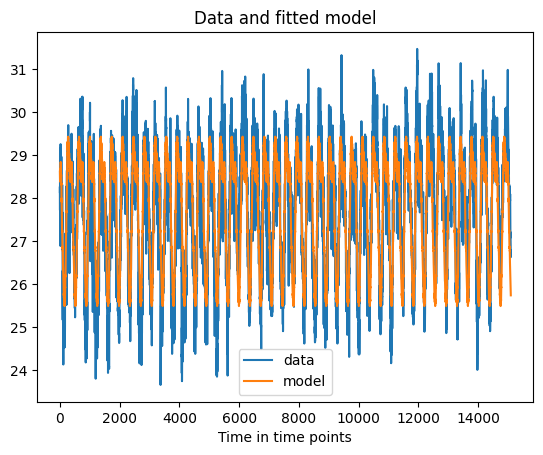

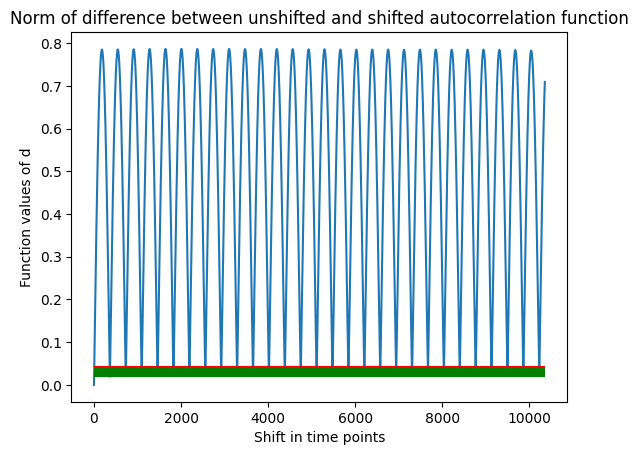

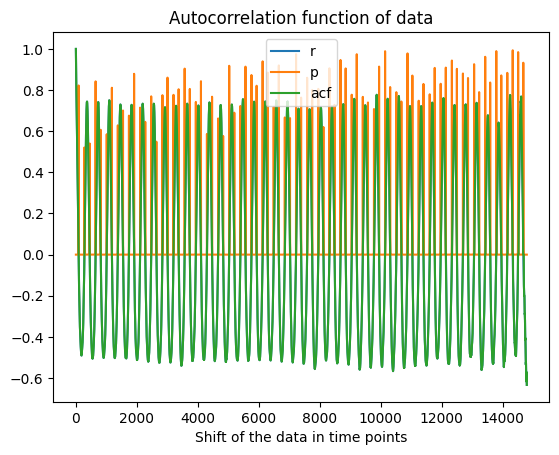

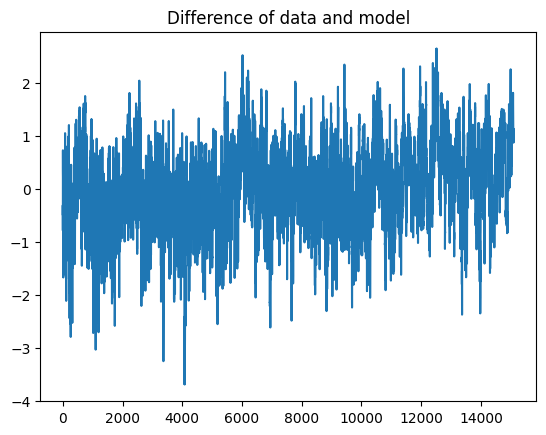

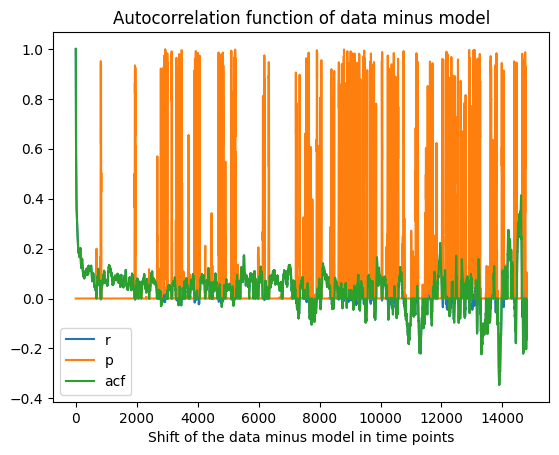

Results(period=525600.0, model=RandomForestRegressor(), criteria=0.9348325541020169)

In [4]:
find_period(path="./dataset/oisst_lat_14.0_lon_112.0.csv")

In [3]:
import torch
peroid_list = 1 / torch.fft.rfftfreq(365)[1:]
patch_sizes = peroid_list.floor().int().unique()
print(patch_sizes)

tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  24,  26,  28,  30,  33,  36,  40,
         45,  52,  60,  73,  91, 121, 182, 365], dtype=torch.int32)


In [4]:
import torch
peroid_list = 1 / torch.fft.rfftfreq(365)[1:]
patch_sizes = peroid_list.ceil().int().unique()
print(patch_sizes)

tensor([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  25,  27,  29,  31,  34,  37,  41,
         46,  53,  61,  73,  92, 122, 183, 365], dtype=torch.int32)
